In [1]:
import io
import os
import pickle
import requests
import numpy as np
import pandas as pd
from actsnfink import *
from shutil import copy
from copy import deepcopy
from astropy.time import Time
import matplotlib.pylab as plt
from distutils.dir_util import copy_tree
from sklearn.ensemble import RandomForestClassifier
from actsnclass.metrics import get_snpcc_metric
from actsnclass.metrics import get_snpcc_metric

In [2]:
fink_colors_list = ['#15284F','#F5622E','#D5D5D3','#3C8DFF']

# Initial configuration

In [3]:
train_first_model = False
strategy = 'UncSampling'            # query strategy

In [4]:
def plot_lc(list_lc,dir_suffix):
    fig = plt.figure(figsize=(12, 6))

    # Colors to plot
    colordic = {1: 'C0', 2: 'C1'}

    # Labels of ZTF filters
    filtdic = {1: 'g', 2: 'r'}

    for filt in filtdic.keys():
        jd = lc.cjd[0][np.where(lc.cfid[0]==filt)[0]] - 2400000.5
        mag = lc.cmagpsf[0][np.where(lc.cfid[0]==filt)[0]]
        emag = lc.csigmapsf[0][np.where(lc.cfid[0]==filt)[0]]
        plt.errorbar(
            jd,
            mag,
            emag,
            ls = '', marker='o', color=colordic[filt], label=filtdic[filt]
        )


    plt.gca().invert_yaxis()
    # plt.legend()
    plt.title(f"{str(list_lc['objectId'][0])} TNS: {str(list_lc['TNS'][0])}")
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')

    outdir = f'../plots/train_lcs_{dir_suffix}' if dir_suffix!="" else '../plots/train_lcs'
    
    os.makedirs(outdir, exist_ok=True)
    
    plt.savefig(f"{outdir}/{list_lc['objectId'][0]}")

In [45]:
def AL_loop(new_labels, train_for_loop, dir_suffix ="", proba_cut = True, plot_lcs=False,verbose=False):

    dir_output= f'../data_{dir_suffix}/' if dir_suffix!="" else  '../data/'

    if not os.path.exists(f"{dir_output}/initial_state"):
        print("No path",f"{dir_output}/initial_state")
        os.makedirs(dir_output, exist_ok=True)
        # copy initial state
        copy_tree("../data/initial_state", f"{dir_output}/initial_state")
    
    time_counter = 0
    metrics_all_list = []

    for d, date in enumerate(list(new_labels.keys())):
    
        if verbose:
            print("")
            print(date)
        
        # read previous training sample and trained model
        if date == list(new_labels.keys())[0]:
            dir_training = dir_output + date + '/' + strategy  + '/training_samples/train.csv'
            is_file = os.path.isfile(dir_training)
            if is_file and d!=0: # in case no updates were done in training later on
                # if already trained
                print(f'Read {date}')
                train_for_loop = pd.read_csv(dir_training, index_col=False)
                clf_before = pickle.load(open(dir_output +  date + '/' + strategy + '/models/model.pkl', 'rb'))
                train_for_loop_probas = pd.read_csv(dir_training.replace('train.csv','probabilities.csv'), index_col=False)
            else:
                print('Read initial state')
                train_for_loop = pd.read_csv(dir_output + 'initial_state/' + strategy + \
                                                '/training_samples/train_after_loop.csv', 
                                                index_col=False)
                
                train_for_loop_probas = pd.DataFrame()
                train_for_loop_probas['objectId'] = train_for_loop['objectId'].values
                train_for_loop_probas['probability'] = np.zeros(len(train_for_loop))
                
                clf_before = pickle.load(open(dir_output + 'initial_state/' + strategy + \
                                                '/models/model.pkl', 'rb'))
        else:
            is_file = False
            indx = list(new_labels.keys()).index(date) - 1
            
            while not is_file and indx >= 0:
                
                date_before = list(new_labels.keys())[indx]

                is_file = os.path.isfile(dir_output + date_before + \
                                              '/' + strategy  + \
                                              '/training_samples/train.csv')
                
                if is_file:
                    train_for_loop = pd.read_csv(dir_output +  date_before + \
                                              '/' + strategy  + \
                                              '/training_samples/train.csv', 
                                              index_col=False)    
            
                    clf_before = pickle.load(open(dir_output +  date_before + '/' + strategy + \
                                               '/models/model.pkl', 'rb'))
                    
                    train_for_loop_probas = pd.read_csv(dir_output +  date_before + \
                                              '/' + strategy  + \
                                              '/training_samples/probabilities.csv', index_col=False)
                    print(f'Read {date_before} state')
                else:
                    indx = indx - 1
        # print(f'Read training {len(train_for_loop)}')
    
        ########################################################################
        ### create directory structure
        dirname_output = dir_output +  date + '/'
        
        for name in [dirname_output + '/', 
                     dirname_output + '/' + strategy + '/', 
                     dirname_output + '/' + strategy + '/models/', 
                     dirname_output + '/' + strategy + '/class_prob/',
                     dirname_output + '/' + strategy + '/metrics/', 
                     dirname_output + '/' + strategy + '/queries/',
                     dirname_output + '/' + strategy + '/training_samples/', 
                     dirname_output + '/' + strategy + '/test_samples/']:
            if not os.path.isdir(name):
                os.makedirs(name)
    
        #######################################################################
        ### Get alert data
        
        alerts_list = []
    
        for i in range(new_labels[date].shape[0]):
            
            name = new_labels[date][i][0]
            # print(name)
    
            r = requests.post(
                'https://fink-portal.org/api/v1/objects',
                json={
                    'objectId':name,
                    'output-format': 'json',
                    'withupperlim': 'True' # online ML uses bad quality
                }
            )

            try:
                # Format output in a DataFrame
                pdf = pd.read_json(io.BytesIO(r.content))
                pdf = pdf[pdf['d:tag'] != 'upperlim'] #using valid and badquality detections
            except Exception:
                pdf= pd.DataFrame()
    
            if pdf.shape[0] == 0:
                print(f"No alerts found for object: {name}")
                # raise ValueError('No alerts found for object: ', name)
            else:
                # add label
                pdf['type'] = new_labels[date][i][1]

                if verbose:
                    print(f'Got data for {name}')
        
                alerts_list.append(pdf)
    
        if len(alerts_list)>0:
            alerts_pd = pd.concat(alerts_list, ignore_index=True)
        
            #############################################################################
            #### feature extract for each date
            
            alerts_format_list = []
        
            for indx_obj in range(new_labels[date].shape[0]):
                
                # isolate one object
                flag_obj = alerts_pd['i:objectId'].values == new_labels[date][indx_obj][0]
        
                # separate only dates until the alert was sent to follow-up
                cjd = alerts_pd[flag_obj]['i:jd'].values
                flag_jd = cjd < float(new_labels[date][indx_obj][2])

                # for ZTF, some light-curves were not available before classification
                # check that there is data to use
                if len(alerts_pd[flag_obj]['i:jd'].values[flag_jd])>0: 
                    
                    #flag_jd = np.array([True for i in range(cjd.shape[0])])
                    lc = pd.DataFrame([[new_labels[date][indx_obj][0], 
                                    alerts_pd[flag_obj]['i:candid'].values[flag_jd][np.argsort(alerts_pd[flag_obj]['i:jd'].values[flag_jd])[-1]],
                                    alerts_pd[flag_obj]['i:jd'].values[flag_jd],         
                                    alerts_pd[flag_obj]['i:fid'].values[flag_jd], 
                                    alerts_pd[flag_obj]['i:magpsf'].values[flag_jd],
                                    alerts_pd[flag_obj]['i:sigmapsf'].values[flag_jd],
                                    new_labels[date][indx_obj][1]]], 
                                    columns=['objectId', 'candid', 'cjd', 'cfid', 'cmagpsf', 'csigmapsf', 'TNS'], index=[0], dtype=object)
                
                    alerts_format_list.append(lc)
                    
                    if plot_lcs:
                        plot_lc(lc)
                        
            if len(alerts_format_list)>0:
                alerts_format_pd = pd.concat(alerts_format_list, ignore_index=True)
            
                # convert from mag to FLUXCAL
                alerts_flux = convert_full_dataset(alerts_format_pd, obj_id_header='objectId')
            
                # extract features
                alerts_features = featurize_full_dataset(alerts_flux, screen=False,
                                                         ewma_window=3, 
                                                          min_rising_points=1, 
                                                          min_data_points=3, rising_criteria='ewma')
            
                # filter alerts with zero in all filters
                flag_zero = np.logical_and(alerts_features['a_g'].values == 0.0,alerts_features['a_r'].values == 0.0)
                # flag_zero = np.logical_or(alerts_features['a_g'].values == 0.0,
                #                            alerts_features['a_r'].values == 0.0)
                alerts_use = deepcopy(alerts_features[~flag_zero])
                # print('    alerts_use.shape = ', alerts_use.shape)
                if verbose:
                    if len(alerts_features[flag_zero])>0:
                        print(f'Missing {alerts_features[flag_zero]["id"]}')
                        print(alerts_flux[alerts_flux['id'].isin(alerts_features[flag_zero]["id"])])
            
                # go through events if they have at least one band with features
                if alerts_use.shape[0] > 0:
                    
                    alerts_use.rename(columns={'id':'objectId'}, inplace=True)
                    alerts_use['loop'] = list(new_labels.keys()).index(date) + 30
                
                    # see what current model says about queried alerts
                    pred_prob_query = clf_before.predict_proba(alerts_use[list(alerts_use.keys())[2:-1]])

                    probabilities_list= []
                    if proba_cut:
                        keep_index = []
                        for j in range(len(pred_prob_query)):
                            if (pred_prob_query[j][0]>0.4) & (pred_prob_query[j][0]<0.6):
                                keep_index.append(j)
                                probabilities_list.append(pred_prob_query[j][0])
                        new_alerts_use = alerts_use.iloc[keep_index]
                        print(probabilities_list)
                    else:
                        new_alerts_use = alerts_use
                        probabilities_list= pred_prob_query[:,0].flatten()
                    if verbose:
                        print(f"New alerts to use {len(new_alerts_use)}")
            
                    if len(new_alerts_use) > 0:
     
                        # update training
                        train_updated = pd.concat([train_for_loop, new_alerts_use], ignore_index=True)
                        if verbose:
                            print('    train_updated.shape = ', train_updated.shape)
                            
                        # save probabilities:
                        proba_out = np.append(train_for_loop_probas['probability'].values, probabilities_list)
                        train_for_loop_probas = pd.DataFrame()
                        train_for_loop_probas['objectId'] = train_updated['objectId'].values
                        train_for_loop_probas['probability'] = proba_out
                        train_for_loop_probas.to_csv(dir_output + date +'/' + strategy  + '/training_samples/probabilities.csv', index=False)

                        # save to file
                        train_updated.to_csv(dir_output + date +'/' + strategy  + \
                                                          '/training_samples/train.csv', 
                                                           index=False)
                    
                        # train model
                        clf = RandomForestClassifier(random_state=42, n_estimators=1000)
                        clf.fit(train_updated[list(train_updated.keys())[:-3]], 
                                    train_updated['type'].values == 'Ia')
                    
                        # make predictions
                        pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
                        pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])
                        
                        # save mode
                        pickle.dump(clf, open(dir_output + date + '/' + strategy + '/models/model.pkl', 
                                                  'wb'))
                    
                        # save predictions
                        pred_prob_pd = pd.DataFrame(np.hstack([test_for_loop['objectId'].values.reshape(-1,1), 
                                                        np.array(pred_prob[:,1]).reshape(-1,1)]), 
                                                        columns=['objectId','probIa'])
                        pred_prob_pd.to_csv(dir_output +  date + '/' + strategy + \
                                            '/class_prob/test_class_prob.csv', index=False)
                
                        # calculate metrics
                        names, res = get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')
                        # print('   res = ', res)
                        
                        metric_pd = pd.DataFrame([[date] + [list(new_labels.keys()).index(date) + 30] + res + \
                                                     [list(alerts_use['objectId'].values)]],columns=['date','loop'] + names + ['query_objectIds'])
                        metric_pd['date_plot'] = d 

                        metric_pd.to_csv(dir_output +  date +'/' + strategy  + \
                                                          '/metrics/metric.csv', 
                                                           index=False)
                        metrics_all_list.append(metric_pd)

                        
    if len(metrics_all_list)>0:        
        metrics = pd.concat(metrics_all_list, ignore_index=True)
        metrics['n spectra']= metrics['query_objectIds'].apply(lambda x: len(x)).cumsum()

    else:
        metrics = pd.DataFrame()

    return metrics

In [7]:
# read train and test data for loop
train_for_loop = pd.read_csv( '../data/initial_state/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index_col=False)

test_for_loop = pd.read_csv('../data/initial_state/' + strategy + \
                                           '/test_samples/test_after_loop.csv', 
                                           index_col=False)

In [8]:
print(f"Number of training light-curves {len(train_for_loop)}")

Number of training light-curves 40


In [9]:
train_for_loop.groupby('type').count()['c_g']

type
AGN         1
C*          2
EB*         3
Ia         13
Mira        1
QSO         7
RRLyr       4
SLSN-I      1
SNII        3
SNIIP       1
SNIIn       1
SNIb        1
Star        1
Varstar     1
Name: c_g, dtype: int64

In [10]:
test_for_loop['type'].unique()
type_list = ['SN','SNII','Ia', 'SLSN-I','SNIIP', 'SNIIn', 'SLSN-II', 'SNIc', 'SNIb', 'SNIIb', 'SNI','SNIb-pec', 'SNIc-BL','SNII-pec','SNIbn']
test_for_loop = test_for_loop[test_for_loop['type'].isin(type_list)]

In [11]:
# train initial model
clf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf.fit(train_for_loop[list(train_for_loop.keys())[:-3]], train_for_loop['type'].values == 'Ia')

RandomForestClassifier(n_estimators=1000, random_state=42)

In [12]:
# make predictions
pred = clf.predict(test_for_loop[list(test_for_loop.keys())[:-2]])
pred_prob = clf.predict_proba(test_for_loop[list(test_for_loop.keys())[:-2]])

# calculate metrics
get_snpcc_metric(pred, test_for_loop['type'].values == 'Ia')

(['accuracy', 'efficiency', 'purity', 'fom'],
 [np.float64(0.4739316239316239),
  np.float64(0.26212980466288593),
  np.float64(0.8739495798319328),
  np.float64(0.18296308513382645)])

In [13]:
# save mode
pickle.dump(clf, open('../data/initial_state/' + strategy + '/models/model.pkl', 
                      'wb'))

# Fink Siding Spring Observatory follow-up 

In [21]:
# labels from 2.3m SSO, Australia
# here I used the date one day after it was sent to make sure to include all points regardless
# of when the night started

new_labels = {}
new_labels['20230924'] = np.array([['ZTF23abecphw', 'other', Time('2023-09-25', format='iso').jd]]) 
new_labels['20230925'] = np.array([['ZTF23abdhvou', 'Ia', Time('2023-09-26', format='iso').jd]])
new_labels['20230929'] = np.array([['ZTF23abceaws', 'other', Time('2023-09-30', format='iso').jd]])
new_labels['20231005'] = np.array([['ZTF23abhtkba', 'other', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abeudve', 'Ia', Time('2023-10-06', format='iso').jd],
                                   ['ZTF23abggbdy', 'Ia', Time('2023-10-06', format='iso').jd]])
new_labels['20231006'] = np.array([['ZTF23abghfyg', 'Ia', Time('2023-10-07', format='iso').jd]])
new_labels['20231009'] = np.array([['ZTF23abhafym', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgspys', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abglsmj', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgfwhj', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abhublj', 'Ia', Time('2023-10-10', format='iso').jd]])
new_labels['20231013'] = np.array([['ZTF23abgspvs', 'Ia', Time('2023-10-14', format='iso').jd],
                                   ['ZTF23abgnfdv', 'Ia', Time('2023-10-14', format='iso').jd],
                                  ['ZTF23abhzwll', 'Ia', Time('2023-10-14', format='iso').jd]])
new_labels['20231015'] = np.array([['ZTF23abhailb', 'other', Time('2023-10-16', format='iso').jd]])
                                  # ['ZTF23abgfwhj', 'Ia', Time('2023-10-16', format='iso').jd]])
new_labels['20231016'] = np.array([['ZTF23abihzbq', 'Ia', Time('2023-10-17', format='iso').jd]])
new_labels['20231018'] = np.array([['ZTF23abhvsbo', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abiljba', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzlbh', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abixwfv', 'other', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abidsaw', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abhzoyw', 'Ia', Time('2023-10-19', format='iso').jd]])
new_labels['20231019'] = np.array([['ZTF23abkavcl', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abjzkqu', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abkgdei', 'Ia', Time('2023-10-20', format='iso').jd],
                                   # ['ZTF23abidmwl', 'other', Time('2023-10-20', format='iso').jd],
                                  ['ZTF23abjhbcr', 'other', Time('2023-10-20', format='iso').jd]])
new_labels['20231022'] = np.array([['ZTF23abjtozz', 'Ia', Time('2023-10-23', format='iso').jd]])
new_labels['20240224'] = np.array([['ZTF24aaejkyp', 'other', Time('2024-02-25', format='iso').jd]])
new_labels['20240229'] = np.array([['ZTF24aaegskb', 'Ia', Time('2024-03-01', format='iso').jd]])
new_labels['20240404'] = np.array([['ZTF24aahgtjt', 'Ia', Time('2024-04-05', format='iso').jd]])
new_labels['20240405'] = np.array([['ZTF24aahgqwk', 'other', Time('2024-04-06', format='iso').jd]])
new_labels['20240409'] = np.array([['ZTF24aahznij', 'Ia', Time('2024-04-10', format='iso').jd],
                                  ['ZTF24aahuulq', 'Ia', Time('2024-04-10', format='iso').jd]])
new_labels['20240410'] = np.array([['ZTF24aaiftcp', 'Ia', Time('2024-04-11', format='iso').jd],
                                  ['ZTF24aaiehwu', 'Ia', Time('2024-04-11', format='iso').jd]])
new_labels['20240412'] = np.array([['ZTF24aaindpx', 'Ia', Time('2024-04-13', format='iso').jd]])
new_labels['20240413'] = np.array([['ZTF24aaiypmp', 'Ia', Time('2024-04-14', format='iso').jd]])
new_labels['20240414'] = np.array([['ZTF24aahtdhb', 'other', Time('2024-04-15', format='iso').jd]]) #AM
new_labels['20240417'] = np.array([['ZTF24aaieino', 'Ia', Time('2024-04-18', format='iso').jd],])
                                  # ['ZTF24aahznij', 'Ia', Time('2024-04-18', format='iso').jd]]) # already in previous days
new_labels['20240418'] = np.array([['ZTF24aaiigrt', 'Ia', Time('2024-04-21', format='iso').jd],
                                  ['ZTF24aaiafkl', 'other', Time('2024-04-19', format='iso').jd]])
new_labels['20240421'] = np.array([['ZTF24aaikjjk', 'other', Time('2024-04-22', format='iso').jd]])
new_labels['20240423'] = np.array([['ZTF24aajqamj', 'other', Time('2024-04-24', format='iso').jd]])
new_labels['20240503'] = np.array([['ZTF24aajwajo', 'other', Time('2024-05-04', format='iso').jd],
                                  ['ZTF24aajqwsm', 'Ia', Time('2024-05-04', format='iso').jd]])
new_labels['20240504'] = np.array([['ZTF24aakfchb', 'other', Time('2024-05-05', format='iso').jd]])
new_labels['20240505'] = np.array([['ZTF24aakymro', 'Ia', Time('2024-05-06', format='iso').jd]])
new_labels['20240507'] = np.array([['ZTF24aalhjeu', 'other', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalhjml', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalsuwb', 'Ia', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalcflg', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalpgky', 'other', Time('2024-05-08', format='iso').jd]])
new_labels['20240508'] = np.array([['ZTF24aakyqxt', 'Ia', Time('2024-05-09', format='iso').jd],
                                   ['ZTF24aalbzkr', 'Ia', Time('2024-05-09', format='iso').jd]])
new_labels['20240510'] = np.array([['ZTF24aalbkdo', 'Ia', Time('2024-05-11', format='iso').jd]])
new_labels['20240514'] = np.array([['ZTF24aamtsgz', 'Ia', Time('2024-05-15', format='iso').jd]])
new_labels['20240515'] = np.array([['ZTF24aamdfll', 'Ia', Time('2024-05-16', format='iso').jd]])
new_labels['20240521'] = np.array([['ZTF24aaomuhe', 'Ia', Time('2024-05-22', format='iso').jd]])
new_labels['20240601'] = np.array([['ZTF24aaoxbth', 'Ia', Time('2024-06-02', format='iso').jd]])
new_labels['20240622'] = np.array([['ZTF24aarfccy', 'Ia', Time('2024-06-23', format='iso').jd]])
new_labels['20240624'] = np.array([['ZTF24aasfxgh', 'Ia', Time('2024-06-25', format='iso').jd]])
new_labels['20240627'] = np.array([['ZTF24aaqutdf', 'other', Time('2024-06-28', format='iso').jd],['ZTF24aarwwnc', 'other', Time('2024-06-24', format='iso').jd]])
new_labels['20240628'] = np.array([['ZTF24aasmghi', 'Ia', Time('2024-06-29', format='iso').jd]])
new_labels['20240629'] = np.array([['ZTF24aasqcng', 'other', Time('2024-06-30', format='iso').jd]])
new_labels['20240703'] = np.array([['ZTF24aatkrrw', 'other', Time('2024-07-04', format='iso').jd]])
new_labels['20240706'] = np.array([['ZTF24aatfxrw', 'Ia', Time('2024-07-07', format='iso').jd]])
new_labels['20240708'] = np.array([['ZTF24aatqolq', 'other', Time('2024-07-09', format='iso').jd]])
new_labels['20240709'] = np.array([['ZTF24aatccmo', 'Ia', Time('2024-07-10', format='iso').jd]])
new_labels['20240711'] = np.array([['ZTF24aatyini', 'Ia', Time('2024-07-12', format='iso').jd]])
new_labels['20240719'] = np.array([['ZTF24aavttjp', 'other', Time('2024-07-20', format='iso').jd],
                                   ['ZTF24aaudlat', 'Ia', Time('2024-07-20', format='iso').jd]])
new_labels['20240720'] = np.array([['ZTF24aavovrp', 'Ia', Time('2024-07-21', format='iso').jd]])
new_labels['20240722'] = np.array([['ZTF24aavzglr','Ia', Time('2024-07-23', format='iso').jd]])
new_labels['20240724'] = np.array([['ZTF24aawjctx', 'Ia', Time('2024-07-25', format='iso').jd],
                                  ['ZTF24aavapoe', 'Ia', Time('2024-07-25', format='iso').jd]])
new_labels['20240729'] = np.array([['ZTF24aawrofs','Ia', Time('2024-07-30', format='iso').jd]])
new_labels['20240731'] = np.array([['ZTF24aaxmalj','Ia', Time('2024-08-01', format='iso').jd]])
new_labels['20240804'] = np.array([['ZTF24aaxmpyh','other', Time('2024-08-05', format='iso').jd]])
new_labels['20240805'] = np.array([['ZTF24aawxqj','Ia', Time('2024-08-06', format='iso').jd]])
new_labels['20240806'] = np.array([['ZTF24aaxmacd','Ia', Time('2024-08-07', format='iso').jd],
                                   ['ZTF24aaxmnqo','Ia', Time('2024-08-07', format='iso').jd]
                                  ])
# labels to be added
new_labels['20240806'] = np.array([['ZTF24aawzlfb','other', Time('2024-08-07', format='iso').jd]])
new_labels['20240807'] = np.array([['ZTF24aaxmpne','Ia', Time('2024-08-08', format='iso').jd]])
new_labels['20240808'] = np.array([['ZTF24aaxqnbe','other', Time('2024-08-09', format='iso').jd],
                                  ['ZTF24aaygegk','Ia', Time('2024-08-09', format='iso').jd]])
new_labels['20240811'] = np.array([['ZTF24aaymouy','Ia', Time('2024-08-12', format='iso').jd]])
new_labels['20240812'] = np.array([['ZTF24aaxzjdt','Ia', Time('2024-08-13', format='iso').jd],
                                   ['ZTF24abakgyn','Ia', Time('2024-08-13', format='iso').jd],
                                   ['ZTF24aayyqub','Ia', Time('2024-08-13', format='iso').jd]])
new_labels['20240813'] = np.array([['ZTF24aazkvzi','Ia', Time('2024-08-14', format='iso').jd]])



In [20]:
metrics_fink_all = AL_loop(new_labels, train_for_loop, dir_suffix ="", proba_cut = False, plot_lcs=False,verbose=True)


20230924
Read initial state
Got data for ZTF23abecphw
New alerts to use 1
    train_updated.shape =  (41, 15)

20230925
Read 20230924 state
Got data for ZTF23abdhvou
New alerts to use 1
    train_updated.shape =  (42, 15)

20230929
Read 20230925 state
Got data for ZTF23abceaws
New alerts to use 1
    train_updated.shape =  (43, 15)

20231005
Read 20230929 state
Got data for ZTF23abhtkba
Got data for ZTF23abeudve
Got data for ZTF23abggbdy
New alerts to use 3
    train_updated.shape =  (46, 15)

20231006
Read 20231005 state
Got data for ZTF23abghfyg
New alerts to use 1
    train_updated.shape =  (47, 15)

20231009
Read 20231006 state
Got data for ZTF23abhafym
Got data for ZTF23abgspys
Got data for ZTF23abglsmj
Got data for ZTF23abgfwhj
Got data for ZTF23abhublj
New alerts to use 5
    train_updated.shape =  (52, 15)

20231013
Read 20231009 state
Got data for ZTF23abgspvs
Got data for ZTF23abgnfdv
Got data for ZTF23abhzwll
New alerts to use 3
    train_updated.shape =  (55, 15)

20231015

In [26]:
metrics_fink_all.to_csv('../data/' + 'metrics.csv', index=False)

# Fink Siding Spring Observatory follow-up + probability cut

In [46]:
metrics_fink_probacut = AL_loop(new_labels, train_for_loop, dir_suffix='probacut', proba_cut = True,verbose=True)


20230924
Read initial state
Got data for ZTF23abecphw
[np.float64(0.439)]
New alerts to use 1
    train_updated.shape =  (41, 15)

20230925
Read 20230924 state
Got data for ZTF23abdhvou
[np.float64(0.481)]
New alerts to use 1
    train_updated.shape =  (42, 15)

20230929
Read 20230925 state
Got data for ZTF23abceaws
[]
New alerts to use 0

20231005
Read 20230925 state
Got data for ZTF23abhtkba
Got data for ZTF23abeudve
Got data for ZTF23abggbdy
[np.float64(0.421)]
New alerts to use 1
    train_updated.shape =  (43, 15)

20231006
Read 20231005 state
Got data for ZTF23abghfyg
[np.float64(0.538)]
New alerts to use 1
    train_updated.shape =  (44, 15)

20231009
Read 20231006 state
Got data for ZTF23abhafym
Got data for ZTF23abgspys
Got data for ZTF23abglsmj
Got data for ZTF23abgfwhj
Got data for ZTF23abhublj
[np.float64(0.55), np.float64(0.47)]
New alerts to use 2
    train_updated.shape =  (46, 15)

20231013
Read 20231009 state
Got data for ZTF23abgspvs
Got data for ZTF23abgnfdv
Got dat

# Non-Fink follow-up

Obtained from TNS

In [29]:
# Function to convert Time object to desired format
from astropy.time import TimeDelta
def add_days_and_format(x,days):
    # Convert Time object to datetime
    time_obj = Time(x, format='iso') + TimeDelta(days, format='jd')
    dt = time_obj.datetime 
    # dt = time_obj.datetime
    # Format datetime to custom format
    return f"{dt.year}{dt.month:02d}{dt.day:02d}"

In [30]:
# read TNS labels
df_tns_tmp = pd.read_parquet('../tns/tns_fink_20230817.parquet')

# constrain date
df_tns_tmp['discoveryjd'] = [Time(d, format='iso').jd for d in df_tns_tmp['discoverydate']]
df_tns = df_tns_tmp[df_tns_tmp['discoveryjd']> Time('2023-09-21', format='iso').jd].copy()

print(f"All TNS {len(df_tns_tmp)}, in range {len(df_tns)}")

# reformat
df_tns['type'] = df_tns['type'].str.strip('(TNS) SN ')
df_tns['type AL'] = df_tns['type'].apply(lambda x: 'Ia' if 'Ia' in x else 'other')

df_tns['discoveryjd+12'] = df_tns['discoveryjd'].apply(lambda x: int(x+12)) # 12 dayS as time to get ~3 measurements in each band
df_tns['discoveryjd+12_strfmt'] = df_tns['discoverydate'].apply(lambda x: add_days_and_format(x, 12))

df_tns['internal_names'] = df_tns['internal_names'].fillna(value="")

All TNS 16778, in range 1804


In [31]:
# Function to extract names starting with 'ZTF'
def extract_ztf_names(row):
    if row:
        ztf_list = [name.strip() for name in row.split(',') if name.strip().startswith('ZTF')]
        if len(ztf_list)>0:
            return ztf_list[0]
        else:
            return ""
    else:
        return ""

# Apply the function to the DataFrame
ztf_tns = df_tns[df_tns['internal_names'].str.contains('ZTF')]
ztf_tns = ztf_tns[['internal_names','type AL','discoveryjd+12','discoveryjd+12_strfmt','type']]
ztf_tns['ztf_names'] = ztf_tns['internal_names'].apply(extract_ztf_names)

# sort
ztf_tns = ztf_tns.sort_values(by='discoveryjd+12')

# test unique
print(f"ZTF detected and spectroscopically classified {len(ztf_tns)}")

# convert to new_labels format
dic_ztf_labels = {}
for dat in ztf_tns['discoveryjd+12'].unique()[:60]:
    sel = ztf_tns[ztf_tns['discoveryjd+12']==dat]
    tmp_arr = sel[['ztf_names','type AL','discoveryjd+12']].to_numpy()

    date_in_str_fmt = sel['discoveryjd+12_strfmt'].values[0]
    dic_ztf_labels[date_in_str_fmt] = tmp_arr

ZTF detected and spectroscopically classified 1331


In [ ]:
# Stats of ZTF spec sample
ztf_tns.groupby('type').count()

,internal_names,type AL,discoveryjd+12,discoveryjd+12_strfmt,ztf_names
type,,,,,
,7,7,7,7,7
AG,7,7,7,7,7
CV,18,18,18,18,18
DE,11,11,11,11,11
DE-He,1,1,1,1,1
FBO,1,1,1,1,1
Galaxy,7,7,7,7,7
Gap,1,1,1,1,1
I,1,1,1,1,1


In [ ]:
# if loading ZTF manually
# tmp1= pd.read_csv('../tns/tns-ZTFfoundandclassed_20230921_20231020.csv')
# tmp2 = pd.read_csv('../tns/tns-ZTFfoundandclassed_20240216_20240230.csv')
# tmp3 = pd.read_csv('../tns/tns-ZTFfoundandclassed_20240424_20240629.csv')
# tmp4 = pd.read_csv('../tns/tns-ZTFfoundandclassed_20240630_20240731.csv')

# tmp = pd.concat([tmp1,tmp2,tmp3,tmp4],ignore_index=True)
# tmp['type'] = tmp['Obj. Type'].str.strip('SN ')
# tmp['type AL'] = tmp['type'].apply(lambda x: 'Ia' if 'Ia' in x else 'other')
# tmp['discoveryjd'] = [Time(d, format='iso').jd for d in tmp['Discovery Date (UT)']]
# tmp['discoveryjd+12'] = tmp['discoveryjd'].apply(lambda x: int(x+12)) # 12 dayS as time to get ~3 measurements in each band
# tmp['discoveryjd+12_strfmt'] = tmp['Discovery Date (UT)'].apply(lambda x: add_days_and_format(x, 12))
# ztf_tns = tmp[['Disc. Internal Name','type AL','discoveryjd+12','discoveryjd+12_strfmt']]

# print(f"Number of ZTF spectra available in this time frame {len(ztf_tns)}")

# # convert to new_labels format
# dic_ztf_labels = {}
# for dat in ztf_tns['discoveryjd+12'].unique():
#     sel = ztf_tns[ztf_tns['discoveryjd+12']==dat]
#     tmp_arr = sel[['Disc. Internal Name','type AL','discoveryjd+12']].to_numpy()

#     date_in_str_fmt = sel['discoveryjd+12_strfmt'].values[0]
#     dic_ztf_labels[date_in_str_fmt] = tmp_arr

In [36]:
metrics_ztf = AL_loop(dic_ztf_labels, train_for_loop, dir_suffix='ZTF', proba_cut = False,verbose=True)

No path ../data_ZTF//initial_state

20231003
Read initial state
Got data for ZTF23abkoshi
Got data for ZTF23abglsmj
New alerts to use 1
    train_updated.shape =  (41, 15)

20231004
Read 20231003 state
Got data for ZTF23abfubfc
Got data for ZTF23abgwvkv
Got data for ZTF23abgbwok
New alerts to use 3
    train_updated.shape =  (44, 15)

20231005
Read 20231004 state
Got data for ZTF23abgnkrr
Missing 0    ZTF23abgnkrr
Name: id, dtype: object
             id type           MJD FLT      FLUXCAL  FLUXCALERR
0  ZTF23abgnkrr   Ia  2.460221e+06   g  4197.210977  542.378401
1  ZTF23abgnkrr   Ia  2.460216e+06   g  4362.746713  453.358019
2  ZTF23abgnkrr   Ia  2.460214e+06   r  2938.956784  286.338340
3  ZTF23abgnkrr   Ia  2.460212e+06   r  2673.991362  194.364767

20231006
Read 20231004 state
Got data for ZTF23abgltid
Got data for ZTF23abghttj
Got data for ZTF23abgovnz
Got data for ZTF23abgjggv
Got data for ZTF23abdshvl
Got data for ZTF23abdshyr
Got data for ZTF23abgfwhj
Got data for ZTF23abghfyg


In [40]:
def plot_metrics_listdf(list_df,label_list,plots_dir='./', varx='date_plot',suffix=''):
    plt.figure(figsize=(16,10))
    
    for i,df in enumerate(list_df):

        color_to_use = fink_colors_list[i]
        xlabel = 'date' if varx=='date_plot' else varx
        
        plt.subplot(2,2,1)
        plt.scatter(df[varx].astype(int), df['accuracy'],label=label_list[i],color=color_to_use)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel('accuracy')
        
        plt.subplot(2,2,2)
        plt.scatter(df[varx].astype(int), df['efficiency'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('efficiency')
        
        plt.subplot(2,2,3)
        plt.scatter(df[varx].astype(int), df['purity'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('purity')
        
        plt.subplot(2,2,4)
        plt.scatter(df[varx].astype(int), df['fom'],color=color_to_use)
        plt.xlabel(xlabel)
        plt.ylabel('figure of merit')

    
    plt.savefig(f'{plots_dir}/metrics_superposed_{varx}{suffix}.png')    
    plt.show()

In [41]:
# date reformatting

# convert to new_labels format
dic_ztf_labels_all = {}

# need to use the dates that have alerts that have features
all_dates = np.concat([metrics_ztf['date'].values,metrics_fink_all['date'].values])
all_dates.sort()

# lets put the date_plot in the same baseline using the combining dataset
# mapping
to_merge = pd.DataFrame({'date':all_dates, 'date_plot':np.arange(0,len(all_dates))})

tmp = metrics_fink_all[[k for k in metrics_fink_all.keys() if k!='date_plot']]
metrics_fink_all_tp = pd.merge(tmp, to_merge, on='date',how='left')

tmp = metrics_fink_probacut[[k for k in metrics_fink_probacut.keys() if k!='date_plot']]
metrics_fink_probacut_tp = pd.merge(tmp, to_merge, on='date',how='left')

tmp = metrics_ztf[[k for k in metrics_ztf.keys() if k!='date_plot']]
metrics_ztf_tp = pd.merge(tmp, to_merge, on='date',how='left')

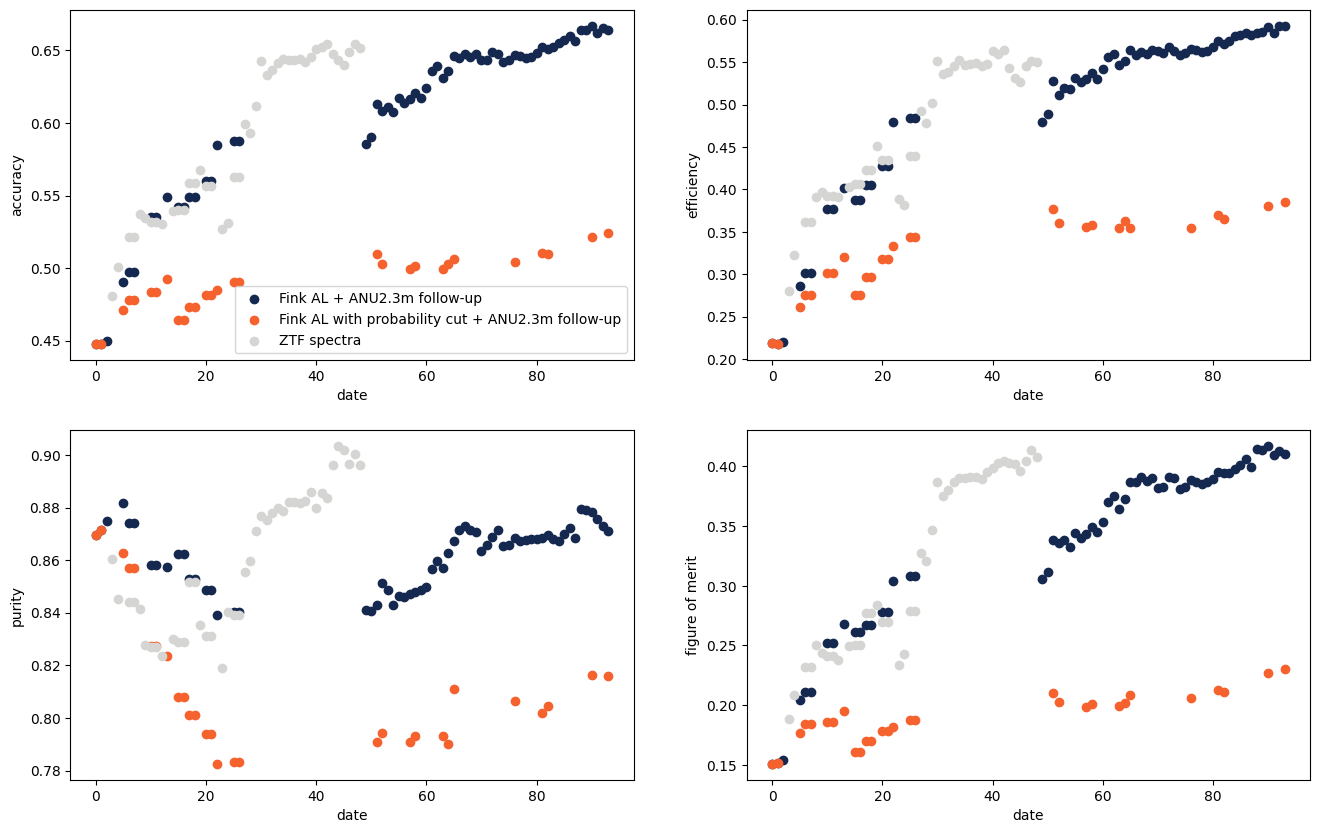

In [42]:
# not completely true as ZTF spectra dates are different than Fink AL ones
plot_metrics_listdf([metrics_fink_all_tp,metrics_fink_probacut_tp,metrics_ztf_tp],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'])

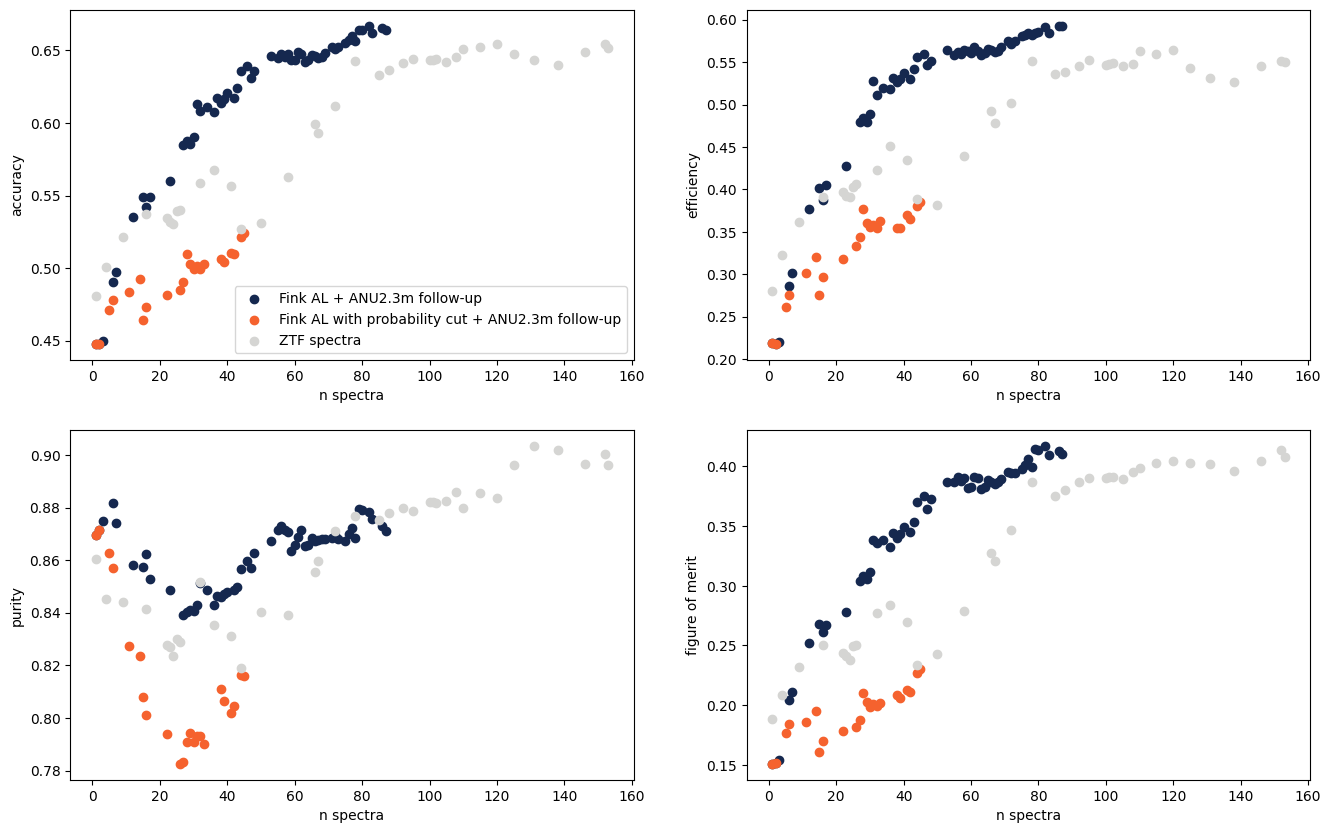

In [43]:
plot_metrics_listdf([metrics_fink_all,metrics_fink_probacut,metrics_ztf],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'],varx='n spectra')

# combining our tags with ZTF ones

In [ ]:
# convert to new_labels format
dic_ztf_labels_all = {}

# need to use the dates that have alerts that have features
all_dates = np.concat([metrics_ztf['date'].values,metrics_fink_all['date'].values])
all_dates.sort()

for dat in all_dates: 
    # print(dat)
    try:
        tmp_arr_fink = new_labels[dat]
        # print('Fink',tmp_arr_fink)
    except Exception:
        tmp_arr_fink = []
        # print('no Fink')
    
    if len(ztf_tns[ztf_tns['discoveryjd+12_strfmt']==dat])<1:
        dummy = []
        # print('No ZTF')
    
    sel = ztf_tns[ztf_tns['discoveryjd+12_strfmt']==dat]
    tmp_arr_ztf = sel[['Disc. Internal Name','type AL','discoveryjd+12']].to_numpy()

    # print('ZTF',tmp_arr_ztf)

    if len(tmp_arr_fink)>0 and len(tmp_arr_fink)>0:
        # print('big combine')
        arr_out = np.concatenate([tmp_arr_ztf, tmp_arr_fink])
    elif len(tmp_arr_fink)>0:
        # print('fink')
        arr_out = tmp_arr_fink
    elif len(tmp_arr_ztf)>0:
        # print('ztf')
        arr_out = tmp_arr_ztf
        
    dic_ztf_labels_all[dat] = arr_out
    

In [ ]:
metrics_ztf_fink = AL_loop(dic_ztf_labels_all, train_for_loop, dir_suffix='ZTF_Fink', proba_cut = False)

20230921
    train_updated.shape =  (41, 15)
20230925
    train_updated.shape =  (42, 15)
20231005
    train_updated.shape =  (45, 15)
20231006
    train_updated.shape =  (46, 15)
20231009
    train_updated.shape =  (50, 15)
20231013
    train_updated.shape =  (53, 15)
20231015
    train_updated.shape =  (54, 15)
20231016
    train_updated.shape =  (56, 15)
20231018
    train_updated.shape =  (61, 15)
20231019
    train_updated.shape =  (65, 15)
20231021
    train_updated.shape =  (66, 15)
20231022
    train_updated.shape =  (67, 15)
20231025
    train_updated.shape =  (68, 15)
20231027
    train_updated.shape =  (71, 15)
20240224
    train_updated.shape =  (72, 15)
20240229
    train_updated.shape =  (73, 15)
20240404
    train_updated.shape =  (74, 15)
20240405
    train_updated.shape =  (75, 15)
20240409
    train_updated.shape =  (77, 15)
20240410
    train_updated.shape =  (79, 15)
20240412
    train_updated.shape =  (80, 15)
20240414
    train_updated.shape =  (81, 15)
20240416
 

In [ ]:
# lets put the date_plot in the same baseline using the combining dataset

# mapping
to_merge = metrics_ztf_fink[['date','date_plot']]
tmp = metrics_fink_all[[k for k in metrics_fink_all.keys() if k!='date_plot']]
metrics_fink_all_tp = pd.merge(tmp, to_merge, on='date',how='left')

tmp = metrics_fink_probacut[[k for k in metrics_fink_probacut.keys() if k!='date_plot']]
metrics_fink_probacut_tp = pd.merge(tmp, to_merge, on='date',how='left')

tmp = metrics_ztf[[k for k in metrics_ztf.keys() if k!='date_plot']]
metrics_ztf_tp = pd.merge(tmp, to_merge, on='date',how='left')

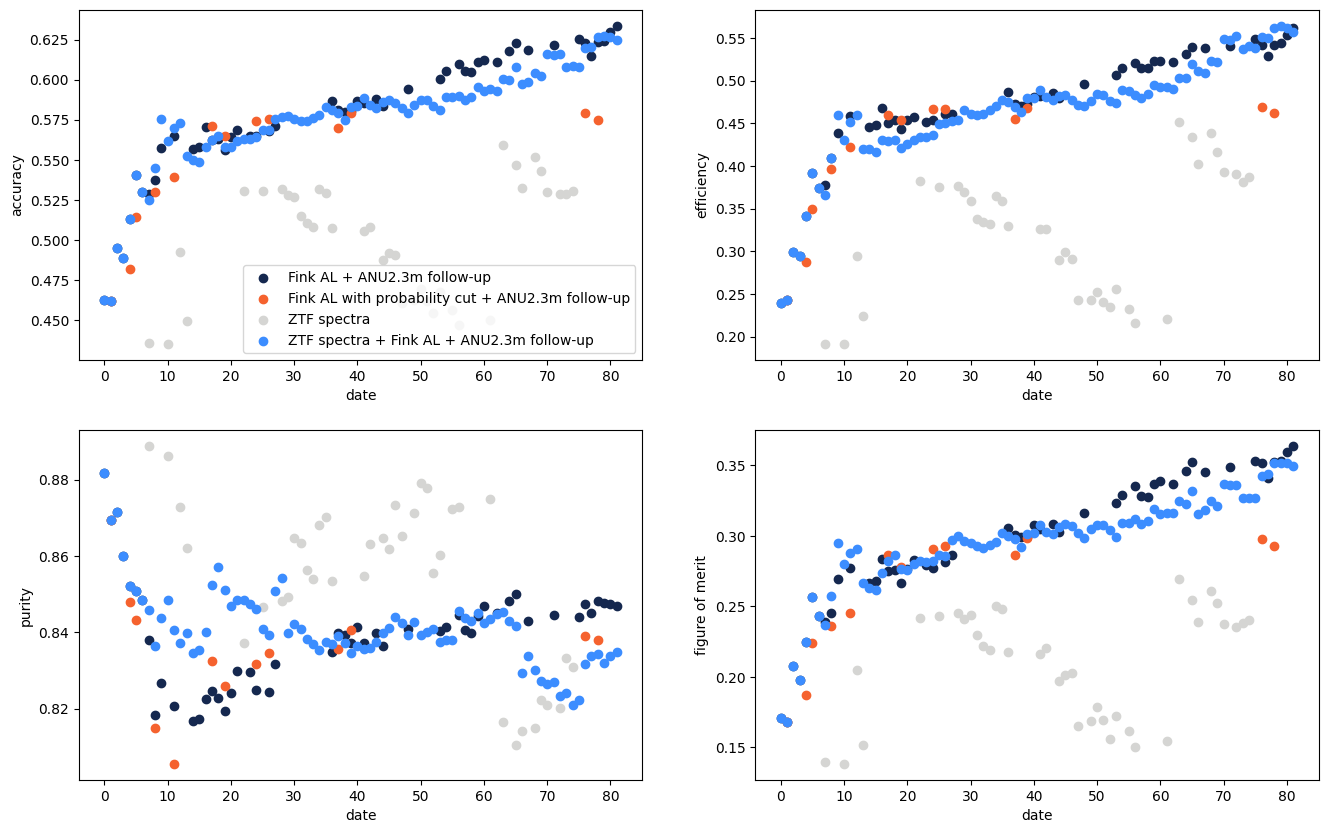

In [ ]:
# for combined dates, it doesnt make sense to use the counter....
plot_metrics_listdf([metrics_fink_all_tp,metrics_fink_probacut_tp,metrics_ztf_tp,metrics_ztf_fink],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra', 'ZTF spectra + Fink AL + ANU2.3m follow-up'],suffix='mixedsamples',varx='date_plot')

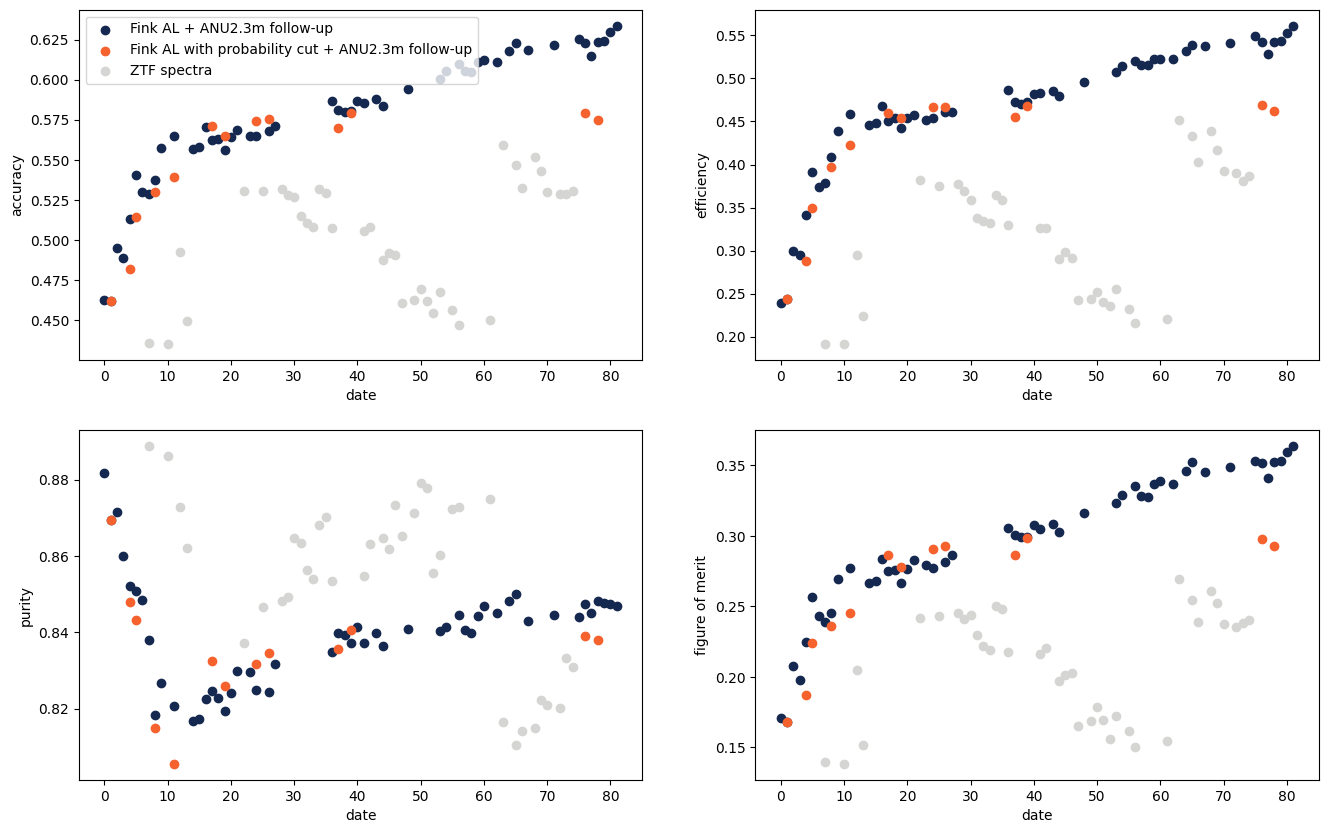

In [ ]:
# for combined dates, it doesnt make sense to use the counter....
plot_metrics_listdf([metrics_fink_all_tp,metrics_fink_probacut_tp,metrics_ztf_tp],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra'],suffix='mixedsamples_gooddatecounter',varx='date_plot')

In [ ]:
print('Labels used in the analysis')
labels = ['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra']
for i, df in enumerate([metrics_fink_all_tp,metrics_fink_probacut_tp,metrics_ztf_tp]):
        print(df['n spectra'].max(),labels[i])

Labels used in the analysis
79 Fink AL + ANU2.3m follow-up
29 Fink AL with probability cut + ANU2.3m follow-up
64 ZTF spectra
